# 이제까지 만들었던 모델을 튜닝하고 배포하기

## 0. 모델 고정해서 사용하기
* CIFAR10 프로젝트를 기반으로 데이터를 수정하고 하이퍼파라미터 튜닝을 한 다음 배포

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.6.0
2.9.0


### 0-1. 작업환경 구성하기

In [2]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10_exp07/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/cifar10_exp07/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/cifar10_exp07/training_history

In [68]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


### 0-2. 데이터셋 구성하기

In [69]:
cifar10 = tf.keras.datasets.cifar10

(train_x, train_y), (test_x, test_y) = cifar10.load_data()

train_x.shape, test_y.shape

((50000, 32, 32, 3), (10000, 1))

* 학습에 사용할 train_x의 이미지를 -1, 1로 정규화

In [70]:
#학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
train_x = (train_x.astype('float32') - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


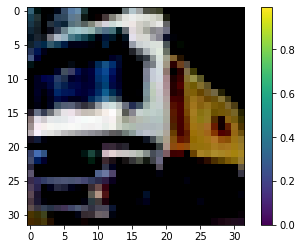

In [71]:
# 첫 번째 이미지 선택
plt.imshow(train_x[1])
plt.colorbar()  #각 픽셀의 값과 그에 따른 색도 확인
plt.show()

* CIFAR10 프로젝트의 경우에는 모델을 고정해서 사용
* 다음과 같은 그림으로 구성
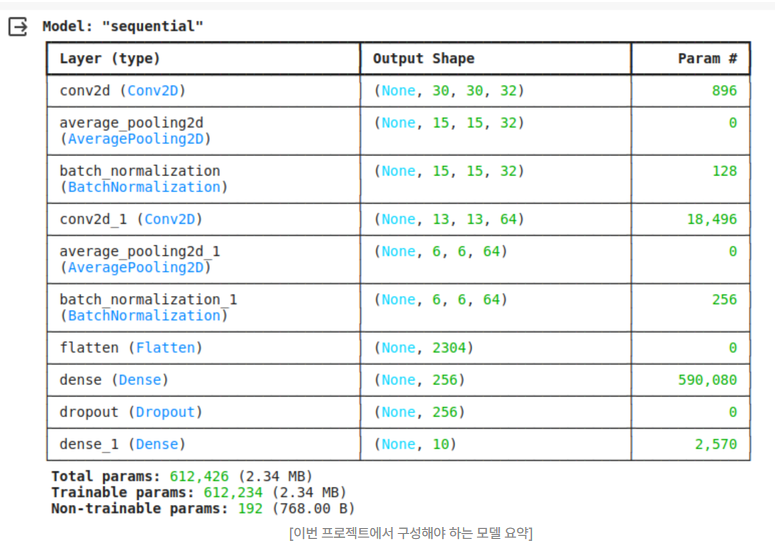

In [72]:
# 모델 구현
def make_cifar10_model():
    #시작
    model = tf.keras.Sequential()
    
    #첫번째 Conv2D 레이어 
    #필터의 크기는 3이며 32개 사용, 입력 값의 크기는 준비된 칼라사진
    model.add(layers.Conv2D(32, (3, 3), input_shape=[32, 32, 3]))
    model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    #배치 정규화 사용
    model.add(layers.BatchNormalization())

    #두번째 Conv2D Layer
    # 필터의 크기는 3이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(64, (3, 3)))
    model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    #배치 정규화 사용
    model.add(layers.BatchNormalization())
    
    #세번째 Flatten Layer
    model.add(layers.Flatten())
    #네번째 Dense Layer
    model.add(layers.Dense(256, activation='relu'))
    #Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))
    #다섯번째 Dense Layer
    model.add(layers.Dense(10, activation='softmax'))  # 출력 클래스가 10개 

    return model

In [73]:
model_cifar10 = make_cifar10_model()

model_cifar10.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d_4 (Average (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_5 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

## 1. Data Centric AI 맛보기

* 훈련 데이터셋과 테스트 데이터셋을 전부 열어서 확인해서 틀린 것이 없는지 검수해야 합니다
* labelerrors.com : Data Centric AI에서 가장 많이 활용하고 있는 파이썬 라이브러리
  - cleanlab을 만든 개발자들이 공개한 사이트
  - 테스트 데이터와 label이 잘못 붙어 있는 사례를 모아 보여줌
  - labelerrors.com에서 CIFAR10 테스트 데이터셋을 확인
* ID를 기준으로 직접 데이터셋을 시각화하고 실제 label이 잘못 붙어있다면 label을 수정

* 잘못된 라벨확인 화면 - 자료는 모두 22개
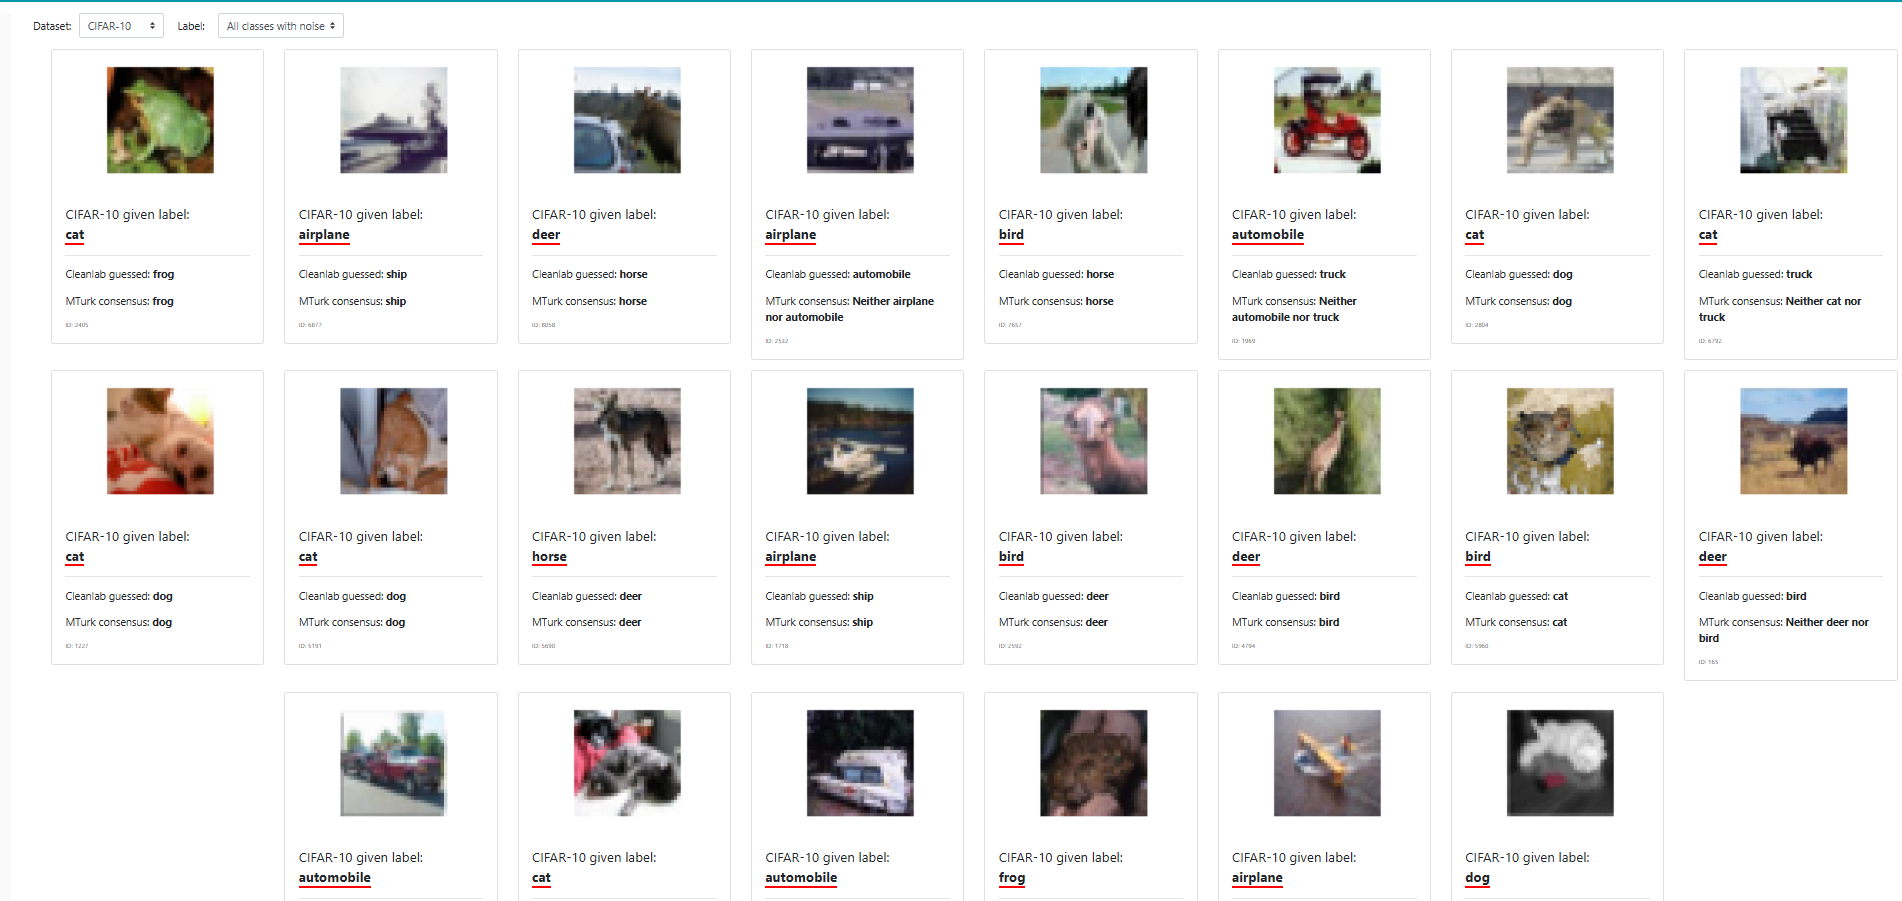

* 잘못된 라벨1개의 이미지 표시
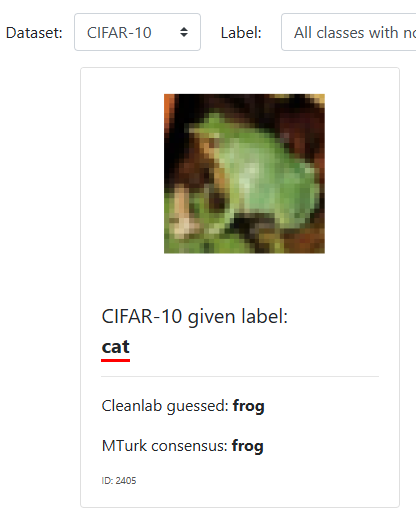

In [74]:
#ID기준 잘못된 자료를 수정하기 (예를들면 cat -> frog)


In [75]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 데이터 로드
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#cifar10 = tf.keras.datasets.cifar10
#(train_x, train_y), (test_x, test_y) = cifar10.load_data()
#train_x.shape, test_y.shape

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

def visualize_and_correct_label(wrong_id):
    for item in wrong_id:
        image_id = item['id']  #해당id
        correct_class = item['class'] #속하는 class그룹
        print('image_id:',image_id)
        print('correct_class:',correct_class)
        
        # 이미지 표시
        plt.imshow(test_x[image_id])  #테스트셋-문제id
        plt.title(f"Original Label: {class_names[test_y[image_id][0]]}")  #테스트셋-라벨-id
        plt.show()
        
        # 실제 현재 레이블 가져오기
        current_label = class_names[test_y[image_id][0]] 
        print('current_label:',current_label)
        
        if current_label != correct_class:
            # 맞는라벨로 테스트_라벨을 변경
            test_y[image_id] = class_names.index(correct_class)
            print(f"'{correct_class}'로 변경. ID: {image_id}")
        else:
            print(f"{image_id}의 라벨이 이미 '{current_label}'입니다.")

image_id: 2405
correct_class: frog


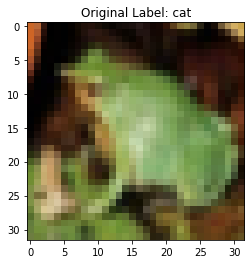

current_label: cat
'frog'로 변경. ID: 2405
image_id: 6877
correct_class: ship


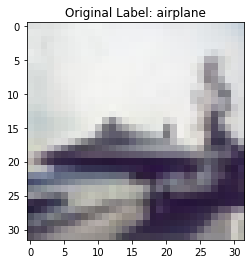

current_label: airplane
'ship'로 변경. ID: 6877
image_id: 8058
correct_class: horse


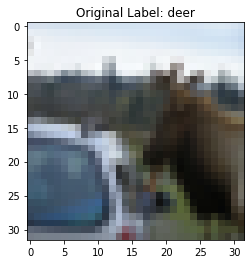

current_label: deer
'horse'로 변경. ID: 8058
image_id: 2532
correct_class: automobile


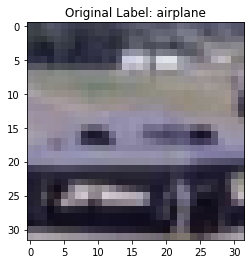

current_label: airplane
'automobile'로 변경. ID: 2532
image_id: 7657
correct_class: horse


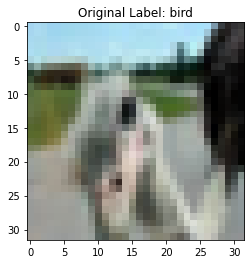

current_label: bird
'horse'로 변경. ID: 7657
image_id: 1969
correct_class: truck


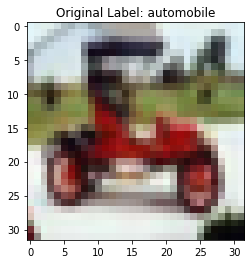

current_label: automobile
'truck'로 변경. ID: 1969
image_id: 2804
correct_class: dog


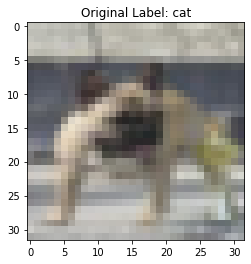

current_label: cat
'dog'로 변경. ID: 2804
image_id: 6792
correct_class: truck


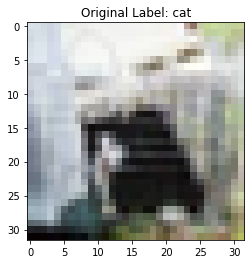

current_label: cat
'truck'로 변경. ID: 6792
image_id: 1227
correct_class: dog


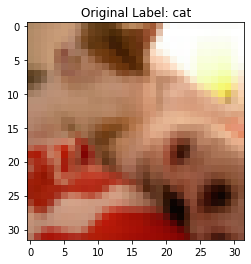

current_label: cat
'dog'로 변경. ID: 1227
image_id: 5191
correct_class: dog


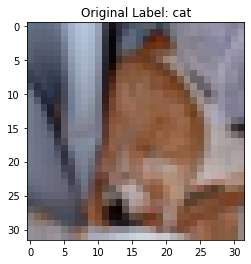

current_label: cat
'dog'로 변경. ID: 5191
image_id: 5690
correct_class: deer


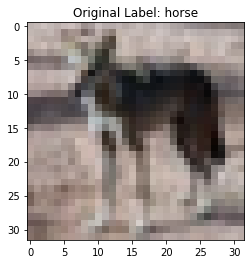

current_label: horse
'deer'로 변경. ID: 5690
image_id: 1718
correct_class: ship


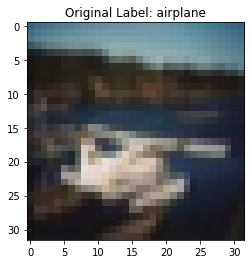

current_label: airplane
'ship'로 변경. ID: 1718
image_id: 2592
correct_class: deer


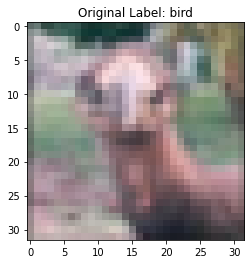

current_label: bird
'deer'로 변경. ID: 2592
image_id: 4794
correct_class: bird


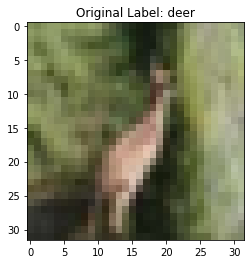

current_label: deer
'bird'로 변경. ID: 4794
image_id: 5960
correct_class: cat


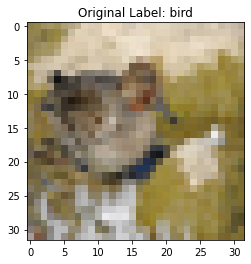

current_label: bird
'cat'로 변경. ID: 5960
image_id: 165
correct_class: bird


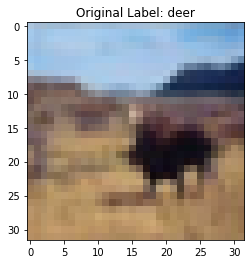

current_label: deer
'bird'로 변경. ID: 165
image_id: 9227
correct_class: truck


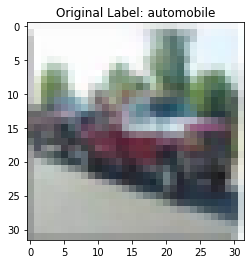

current_label: automobile
'truck'로 변경. ID: 9227
image_id: 5632
correct_class: dog


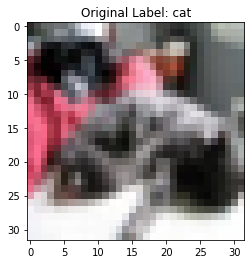

current_label: cat
'dog'로 변경. ID: 5632
image_id: 9352
correct_class: truck


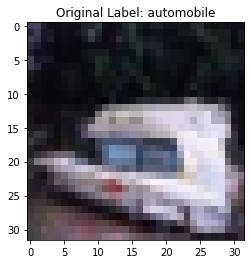

current_label: automobile
'truck'로 변경. ID: 9352
image_id: 7846
correct_class: cat


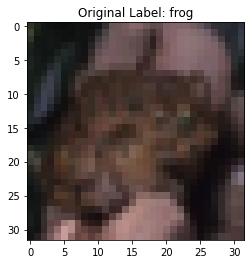

current_label: frog
'cat'로 변경. ID: 7846
image_id: 6966
correct_class: ship


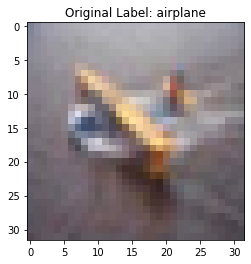

current_label: airplane
'ship'로 변경. ID: 6966
image_id: 5468
correct_class: cat


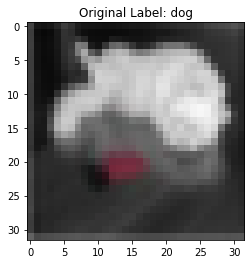

current_label: dog
'cat'로 변경. ID: 5468


In [76]:
wrong_id = [
  {'id': 2405, 'class': 'frog'},
  {'id': 6877, 'class': 'ship'},
  {'id': 8058, 'class': 'horse'},
  {'id': 2532, 'class': 'automobile'},
  {'id': 7657, 'class': 'horse'},
  {'id': 1969, 'class': 'truck'},
  {'id': 2804, 'class': 'dog'},
  {'id': 6792, 'class': 'truck'},
  {'id': 1227, 'class': 'dog'},
  {'id': 5191, 'class': 'dog'},
  {'id': 5690, 'class': 'deer'},
  {'id': 1718, 'class': 'ship'},
  {'id': 2592, 'class': 'deer'},
  {'id': 4794, 'class': 'bird'},
  {'id': 5960, 'class': 'cat'},
  {'id': 165, 'class': 'bird'},
  {'id': 9227, 'class': 'truck'},
  {'id': 5632, 'class': 'dog'},
  {'id': 9352, 'class': 'truck'},
  {'id': 7846, 'class': 'cat'},
  {'id': 6966, 'class': 'ship'},
  {'id': 5468, 'class': 'cat'}
]
visualize_and_correct_label(wrong_id)